# **CSE 5095: Social Media Mining and Analysis**

### **Fall 2024, Assignment #4, 300 points**

In this assignment, we will explore large language models (LLMs)/transformer methods to build a classification framework to separate the observations according to the two subreddits.

**Task 1: BERT-- Feature Word Vectors (20 points)**

Your starting point to build feature word vectors will be the pruned vocabulary that you have determined in
Task 4 of Assignment #2. Generate feature word vectors using BERT for this pruned or shortened
vocabulary. Choose two most prominent words from each subreddit, by considering the word clouds from
Assignment #1. Compute pairwise cosine similarity between the feature vectors computed using
transformers of these four words. 

In [5]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def analyze_vocab_pruning(df, vocab_sizes, random_state=42):
    X = df['combined_text']
    y = df['subreddit']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )
    
    results = []
    for vocab_size in vocab_sizes:
        vectorizer = TfidfVectorizer(
            max_features=vocab_size,
            min_df=5,
            stop_words='english',
            token_pattern=r'\b[a-zA-Z]{3,}\b'
        )
        
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
        rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        rf.fit(X_train_tfidf, y_train)
        
        y_pred = rf.predict(X_test_tfidf)
        
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'vocab_size': vocab_size, 'accuracy': accuracy})
    
    return pd.DataFrame(results)

def combine_text_fields(row):
    fields = [
        str(row['post_title']) if not pd.isna(row['post_title']) else '',
        str(row['post_self_text']) if not pd.isna(row['post_self_text']) else '',
        str(row['self_text']) if not pd.isna(row['self_text']) else ''
    ]
    return ' '.join(field for field in fields if field)

def preprocess_text(text):
    if pd.isna(text) or text is None:
        return ''
    
    text = str(text).lower()
    
    # Remove URLs, punctuation, and digits
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join(text.split())
    
    return text

    
df = pd.read_csv('project10.csv')
df['combined_text'] = df.apply(combine_text_fields, axis=1)
df['combined_text'] = df['combined_text'].apply(preprocess_text)
df = df[df['combined_text'].str.len() > 0].copy()

# Assuming df is your DataFrame with 'combined_text' and 'subreddit' columns
vocab_sizes = [5000, 10000, 20000, 30000, 40000, 50000, 60000]
results_df = analyze_vocab_pruning(df, vocab_sizes)

# Find the optimal vocabulary size (highest accuracy)
optimal_vocab_size = results_df.loc[results_df['accuracy'].idxmax(), 'vocab_size']

print(f"Optimal vocabulary size: {optimal_vocab_size}")

# Use the optimal vocabulary size for further processing
vectorizer = TfidfVectorizer(
    max_features=optimal_vocab_size,
    min_df=5,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)

# Fit the vectorizer on the entire dataset
X = df['combined_text']
pruned_vocab = vectorizer.fit(X)

print(f"Number of features in pruned vocabulary: {len(pruned_vocab.get_feature_names_out())}")

Optimal vocabulary size: 5000
Number of features in pruned vocabulary: 4257


In [8]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

prominent_words = {
    'change': ['fossil', 'emissions'],
    'action': ['action', 'post']
}

def get_bert_embedding(word):
    inputs = tokenizer(word, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

# Generate embeddings for prominent words
word_embeddings = {}
for subreddit, words in prominent_words.items():
    for word in words:
        word_embeddings[f"{subreddit}_{word}"] = get_bert_embedding(word)


# Prepare embeddings for similarity computation
embedding_matrix = np.vstack(list(word_embeddings.values()))

# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(embedding_matrix)

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(
    similarity_matrix, 
    index=word_embeddings.keys(), 
    columns=word_embeddings.keys()
)

print("Pairwise Cosine Similarities:")
print(similarity_df)

Pairwise Cosine Similarities:
                  change_fossil  change_emissions  action_action  action_post
change_fossil          1.000000          0.851418       0.954158     0.935524
change_emissions       0.851418          1.000000       0.844694     0.832352
action_action          0.954158          0.844694       1.000000     0.946961
action_post            0.935524          0.832352       0.946961     1.000000


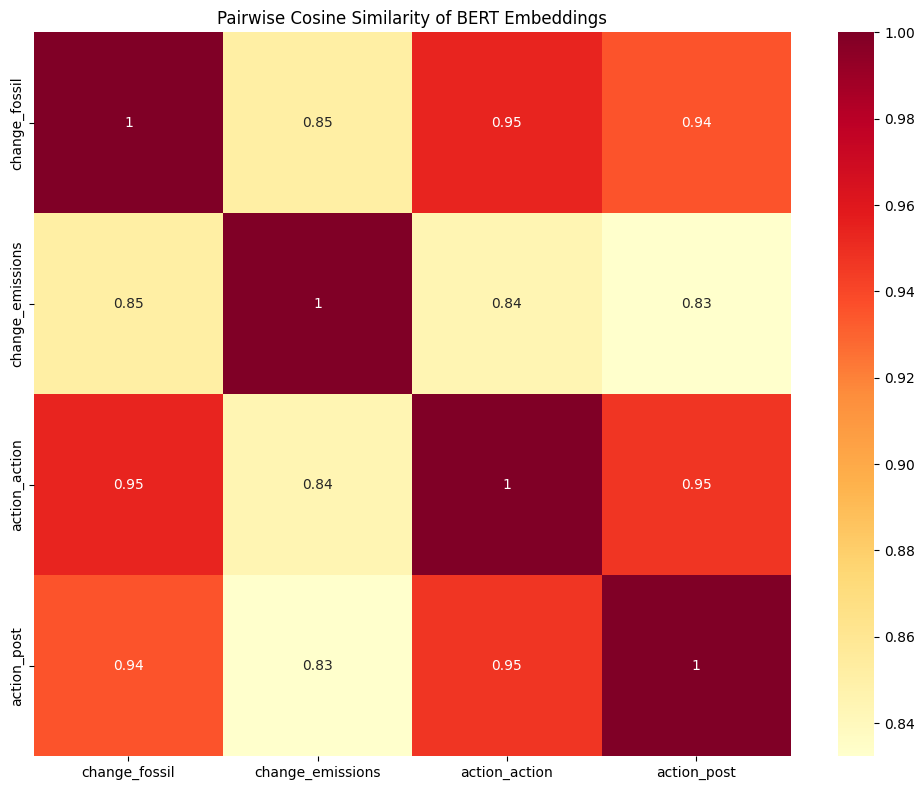

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap='YlOrRd')
plt.title('Pairwise Cosine Similarity of BERT Embeddings')
plt.tight_layout()
plt.show()

**Task 2: Sentence Word Vectors & ML Models (80 points – 10 points, 10 for each aggregation strategy,
and 40 points for four ML models)**

Build sentence vectors based on the feature word vectors. Feed the sentence vectors into the four ML
models used in Assignment #1. Try at least three approaches for aggregating the feature word vectors into
sentence vectors by aggregating the feature word vectors from different layers and compare the
performance metrics for these three approaches. Identify the aggregating approach that offers the best
performance. ML modeling should implement the train/test split and all other details that are outlined in
Assignment #2

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

def get_bert_embeddings(text, aggregation_strategy='mean_last'):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    if aggregation_strategy == 'mean_last':
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    elif aggregation_strategy == 'max_last':
        return outputs.last_hidden_state.max(dim=1)[0].squeeze().numpy()
    elif aggregation_strategy == 'mean_concat_last_4':
        last_four_layers = torch.cat(outputs.hidden_states[-4:], dim=-1)
        return last_four_layers.mean(dim=1).squeeze().numpy()

def generate_sentence_vectors(df, aggregation_strategy):
    return np.array([get_bert_embeddings(text, aggregation_strategy) for text in df['combined_text']])


def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'SVM': SVC(),
        'Naive Bayes': GaussianNB()
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted')
        }
    
    return results

# Generate sentence vectors for each aggregation strategy
aggregation_strategies = ['mean_last', 'max_last', 'mean_concat_last_4']
all_results = {}

for strategy in aggregation_strategies:
    print(f"\nGenerating sentence vectors using {strategy} strategy...")
    X = generate_sentence_vectors(df, strategy)
    y = df['subreddit']
    
    print("Training and evaluating models...")
    results = train_and_evaluate_models(X, y)
    all_results[strategy] = results

# Print results
for strategy, results in all_results.items():
    print(f"\nResults for {strategy} strategy:")
    for model, metrics in results.items():
        print(f"\n{model}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")


Generating sentence vectors using mean_last strategy...
Training and evaluating models...

Generating sentence vectors using max_last strategy...
Training and evaluating models...

Generating sentence vectors using mean_concat_last_4 strategy...
Training and evaluating models...

Results for mean_last strategy:

Logistic Regression:
accuracy: 0.8092
precision: 0.8067
recall: 0.8092
f1: 0.8044

Random Forest:
accuracy: 0.7985
precision: 0.8200
recall: 0.7985
f1: 0.7795

SVM:
accuracy: 0.8229
precision: 0.8305
recall: 0.8229
f1: 0.8130

Naive Bayes:
accuracy: 0.7359
precision: 0.7479
recall: 0.7359
f1: 0.7395

Results for max_last strategy:

Logistic Regression:
accuracy: 0.7878
precision: 0.7845
recall: 0.7878
f1: 0.7851

Random Forest:
accuracy: 0.7695
precision: 0.7796
recall: 0.7695
f1: 0.7487

SVM:
accuracy: 0.8214
precision: 0.8332
recall: 0.8214
f1: 0.8096

Naive Bayes:
accuracy: 0.7053
precision: 0.7106
recall: 0.7053
f1: 0.7075

Results for mean_concat_last_4 strategy:

Logisti

TypeError: '>' not supported between instances of 'dict' and 'dict'

## **Task 3: Fine Tuning BERT (20 points)**

In this task, you will fine tune BERT to build the classification model. You can use the Hugging Face platform.

In [11]:
from sklearn.model_selection import train_test_split

X = df['combined_text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['subreddit'].unique()))

# Custom dataset class for our data
class SubredditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset instances
train_dataset = SubredditDataset(X_train, y_train, tokenizer, max_len=512)
test_dataset = SubredditDataset(X_test, y_test, tokenizer, max_len=512)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and scheduler
optimizer = Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

    model.eval()
    with torch.no_grad():
        total_correct = 0
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predicted = torch.max(logits, dim=1)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / len(test_loader.dataset)
        print(f'Test Accuracy: {accuracy:.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    total_correct = 0
    predictions = []
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)
        total_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())

accuracy = total_correct / len(test_loader.dataset)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1-score: {f1:.4f}')